# Path Segmentation

## Set-up

In [ ]:
!pip install wandb

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 48.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from PIL import Image as PImage

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='path-segmentation')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

In [ ]:
path = '/gdrive/My Drive/Labeling/Segmentation'
image_path = os.path.join(path, 'Data', 'Original')
mask_path = os.path.join(path, 'Data', 'EnumMasks', 'png_0_1')
folder_path = os.path.join(path, 'v3')

get_image_label = lambda x: os.path.join(mask_path, f'{x.stem}_P.png')

In [ ]:
train_images = np.loadtxt(os.path.join(folder_path, 'train.txt'), dtype=str)
test_images = np.loadtxt(os.path.join(folder_path, 'test.txt'), dtype=str)
print(len(train_images), len(test_images))

376 63


#### Get data

In [ ]:
# Image size
img_f = get_image_files(image_path)[0]
mask = open_mask(get_image_label(img_f))
src_size = np.array(mask.shape[1:])
size = src_size//2

# Batch size
bs = 1

# Class names
codes = np.loadtxt(os.path.join(path, 'codes.txt'), dtype=str)
codes

array(['Path,', 'Other'], dtype='<U5')

In [ ]:
np.random.seed(42)
data = (SegmentationItemList
        .from_folder(image_path)
        .filter_by_func(lambda fname: os.path.split(fname)[1] in train_images)
        .split_by_rand_pct(0.175)
        .label_from_func(get_image_label, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

311 311
65 65


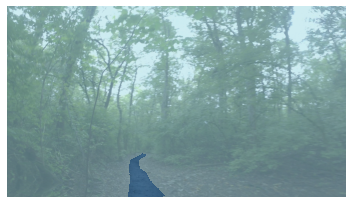

In [ ]:
data.show_batch(figsize=(5,5))

#### Learner

In [ ]:
wd=1e-2

In [ ]:
def acc_segmentation(input, target):
  target = target.squeeze(1)
  return (input.argmax(dim=1)==target).float().mean()

def dice_iou(input, target):
  return dice(input, target, iou=True)

metrics = [acc_segmentation, dice_iou]

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, callback_fns=WandbCallback)
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


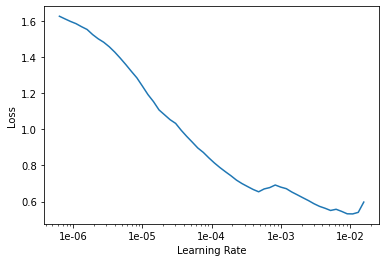

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(8, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time
0,0.105801,0.125104,0.959110,0.957682,05:51
1,0.088671,0.099711,0.963663,0.961708,04:25
2,0.107655,0.104047,0.964386,0.962827,04:20
3,0.099171,0.107207,0.957578,0.955524,04:23
4,0.105197,0.116515,0.961099,0.959182,04:21
5,0.632423,0.112504,0.961549,0.960054,04:20
6,0.110559,0.111643,0.961713,0.959745,04:20
7,0.103429,0.111394,0.957919,0.955696,04:21


Better model found at epoch 0 with valid_loss value: 0.12510408461093903.
Better model found at epoch 1 with valid_loss value: 0.09971117973327637.
Loaded best saved model from /content/wandb/run-20210103_214931-f2tv3c7c/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v3-1-stage-1'))

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v3-1-stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (311 items)
x: SegmentationItemList
Image (3, 1080, 1920),Image (3, 1080, 1920),Image (3, 1080, 1920),Image (3, 1080, 1920),Image (3, 1080, 1920)
y: SegmentationLabelList
ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920)
Path: /gdrive/My Drive/Labeling/Segmentation/Data/Original;

Valid: LabelList (65 items)
x: SegmentationItemList
Image (3, 1080, 1920),Image (3, 1080, 1920),Image (3, 1080, 1920),Image (3, 1080, 1920),Image (3, 1080, 1920)
y: SegmentationLabelList
ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920),ImageSegment (1, 1080, 1920)
Path: /gdrive/My Drive/Labeling/Segmentation/Data/Original;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNor

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time


Loaded best saved model from /content/wandb/run-20210103_214931-f2tv3c7c/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


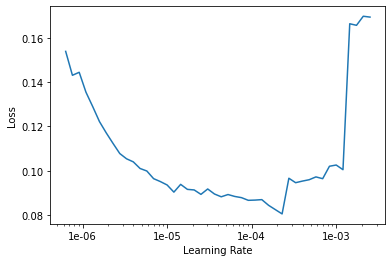

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, slice(lr/1000, lr/10), pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time
0,0.071032,0.087615,0.968455,0.966860,04:18
1,0.099876,0.096041,0.963699,0.961609,04:18
2,0.068112,0.073258,0.972660,0.970936,04:22
3,0.079096,0.069476,0.972328,0.970453,04:24
4,0.076365,0.065218,0.973888,0.972048,04:25
5,0.057724,0.081604,0.973074,0.971801,04:25
6,0.055146,0.066823,0.970747,0.968486,04:25
7,0.054297,0.061283,0.976946,0.975430,04:25


Better model found at epoch 0 with valid_loss value: 0.0876145213842392.
Better model found at epoch 2 with valid_loss value: 0.07325797528028488.
Better model found at epoch 3 with valid_loss value: 0.06947553157806396.
Better model found at epoch 4 with valid_loss value: 0.06521815061569214.
Better model found at epoch 7 with valid_loss value: 0.06128305569291115.
Loaded best saved model from /content/wandb/run-20210103_214931-f2tv3c7c/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v3-1-stage-2'))

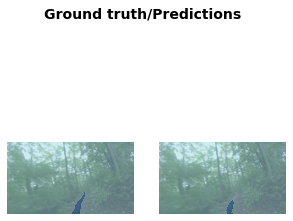

In [ ]:
learn.show_results(rows=1, figsize=(5, 5))

## Evaluate on the test set

In [ ]:
learn.load(os.path.join(folder_path, 'v3-1-stage-2'))

#### Make and visualize predictions on the test set

In [ ]:
pred_path = os.path.join(path, 'Data', 'Predictions_v3.1')
get_pred_path = lambda x: f'{pred_path}/{os.path.splitext(x)[0]}_Pred.png'
get_mask_path = lambda x: f'{mask_path}/{os.path.splitext(x)[0]}_P.png'

count = 0
for filename in test_images:
  infile = os.path.join(image_path, filename)
  if os.path.isdir(infile) or os.path.splitext(infile)[1] != '.jpg':
    continue
  
  # Make prediction
  img = open_image(infile)
  pred = learn.predict(img)

  # Convert mask to [0, 255]
  mask_pred = pred[2].argmax(dim=0)
  mask_pred = mask_pred.numpy()
  rescaled = (255.0/mask_pred.max() * mask_pred - mask_pred.min())
  
  # Resize to 2x
  im = PImage.fromarray(rescaled)
  im = im.convert('L')
  im = im.resize((im.width * 2, im.height * 2))

  # Resize changes some pixels to grey, convert back to [0, 255]
  pixels = np.array(im)
  threshold = 255/2
  pixels[pixels <= threshold] = 0
  pixels[pixels > threshold] = 255

  # Save mask
  im = PImage.fromarray(pixels)
  im.save(get_pred_path(filename))

  # Visualize image with predicted and correct overlay
  _, axs = plt.subplots(1,3, figsize=(15,15))

  lbl_mask = open_mask(get_mask_path(filename))
  pred_mask = open_mask(get_pred_path(filename))

  img.show(ax=axs[0])
  img.show(ax=axs[1], y=lbl_mask)
  img.show(ax=axs[2], y=pred_mask)
  plt.show()

  count += 1
  if count % 10 == 0:
    print(count, '/', len(test_images))

Output hidden; open in https://colab.research.google.com to view.

#### Evaluate metrics from predictions on the test set

In [ ]:
np.random.seed(42)
data_test = (SegmentationItemList
            .from_folder(image_path)
            .filter_by_func(lambda fname: os.path.split(fname)[1] in test_images)
            .split_by_rand_pct(1.0)
            .label_from_func(get_image_label, classes=codes)
            .transform(get_transforms(do_flip=False), size=size, tfm_y=True)
            .databunch(bs=1)
            .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [ ]:
learn.data = data_test

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
acc_segmentation(preds, ys)

tensor(0.9778)

In [ ]:
dice_iou(preds, ys)

tensor(0.9772)